Per poter importare correttamente cv2:

In [29]:
!pip install opencv-python

In [30]:
import cv2
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

# === Funzione: Crop automatico dell'area informativa (cervello) ===
def crop_to_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    return cropped

# === Funzione: Estrazione Color Moments su griglia 10x10 ===
def extract_color_moments(img_path):
    print("[CM10x10] Estrazione in corso...")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")

    if len(img.shape) == 2 or img.shape[2] == 1:
        print("[CM10x10] Immagine in scala di grigi – conversione in RGB finto")
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)  # Crop dell'area utile
    img = cv2.resize(img, (300, 100))

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):  # R, G, B
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk):
                        sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])

    features = np.array(features)
    features = np.nan_to_num(features)

    print(f"[CM10x10] Feature vector (dim {features.shape[0]}): {features[:10]}")
    return features

# === Percorso immagine ===
img_path = "Part1/brain_glioma/brain_glioma_0001.jpg"
features = extract_color_moments(img_path)

[CM10x10] Estrazione in corso...
[CM10x10] Feature vector (dim 900): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.36666667]


Histogram of Oriented Gradients

In [31]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


[HOG] Estrazione in corso...
[HOG] Feature vector (dim 8100): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


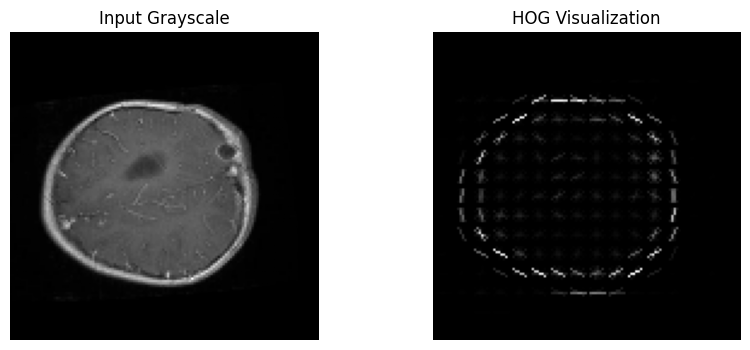

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# === Funzione: Estrazione HOG ===
def extract_hog_features(img_path):
    print("[HOG] Estrazione in corso...")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione fissa

    features, hog_image = hog(resized,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    print(f"[HOG] Feature vector (dim {features.shape[0]}): {features[:10]}")

    # Visualizzazione
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(resized, cmap='gray')
    plt.title("Input Grayscale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis("off")
    plt.show()

    return features

# === Percorso immagine ===
img_path = "Part2/brain_glioma/brain_glioma_1853.jpg"
features = extract_hog_features(img_path)

In [ ]:
import cv2
import numpy as np

def extract_custom_hog(img_path):
    print("[HOG-Custom] Estrazione in corso...")

    # Carica immagine e converti in scala di grigi
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize a 300x10
    resized = cv2.resize(gray, (300, 10))

    h, w = resized.shape
    grid_h, grid_w = h // 10, w // 10  # Cella = 1x30 px
    feature_vector = []

    # Maschere per gradiente
    dx_mask = np.array([[ -1, 0, 1 ]])
    dy_mask = dx_mask.T

    # Gradienti su immagine intera
    dx = cv2.filter2D(resized.astype(np.float32), -1, dx_mask)
    dy = cv2.filter2D(resized.astype(np.float32), -1, dy_mask)
    magnitude = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx) * (180 / np.pi)
    angle = (angle + 360) % 360  # Intervallo [0, 360)

    # Estrazione HOG per ogni cella
    for i in range(10):
        for j in range(10):
            cell_mag = magnitude[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            cell_ang = angle[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]

            hist = np.zeros(9)
            for y in range(cell_mag.shape[0]):
                for x in range(cell_mag.shape[1]):
                    bin_idx = int(cell_ang[y, x] // 40) % 9
                    hist[bin_idx] += cell_mag[y, x]
            feature_vector.extend(hist)

    feature_vector = np.array(feature_vector)
    print(f"[HOG-Custom] Feature vector (dim {len(feature_vector)}): {feature_vector[:10]}")
    return feature_vector

# ESEMPIO USO:
features = extract_custom_hog("Part2/brain_glioma/brain_glioma_1853.jpg")

Task 1:  ResNet-AvgPool-1024: Resize image to 224 x 24; attach a hook to the output of the
“avgpool” layer of the ResNet pre-trained architecture to obtain 2048 dimensional vector,
reduce the number of dimensions of the vector to 1024 by averaging two consecutive entries
in the vector.

In [33]:
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np

class ResNetAvgPool1024Extractor:
    def __init__(self):
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model.eval()
        self.feature = None

        # Hook sul layer avgpool
        def hook_avgpool(module, input, output):
            self.feature = output.squeeze().detach().numpy()

        self.model.avgpool.register_forward_hook(hook_avgpool)

        # Preprocessing: resize, tensor, normalize
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def extract_feature(self, image_path):
        img = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(img).unsqueeze(0)

        with torch.no_grad():
            _ = self.model(input_tensor)

        # self.feature è 2048-dim; riduci a 1024-dim
        avgpool_2048 = self.feature
        avgpool_1024 = 0.5 * (avgpool_2048[::2] + avgpool_2048[1::2])
        return avgpool_1024


# === ESEMPIO USO ===
if __name__ == "__main__":
    image_path = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Sostituisci con il tuo path
    extractor = ResNetAvgPool1024Extractor()
    features = extractor.extract_feature(image_path)

    print("Feature vector (1024 dim):")
    print(features[:10], "...")  # stampa i primi 10 valori

Feature vector (1024 dim):
[0.04737501 0.02057164 0.00852441 0.04339483 0.         0.2076263
 0.12681223 0.0109101  0.         0.        ] ...


HOG:

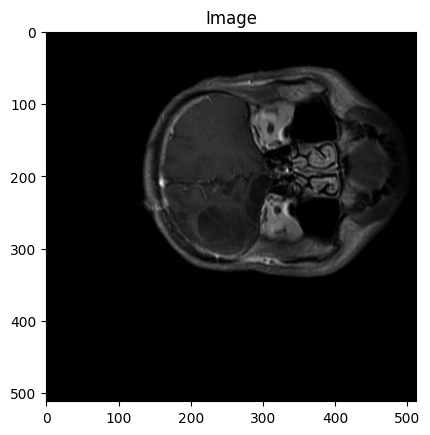

HOG Feature Descriptor:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.92156886e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.42265019e-02
 5.54593606e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30360290e-01 9.45510566e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


In [ ]:
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms import functional as F
import numpy as np
from matplotlib import pyplot as plt

def visualize_image(image_path):
    """
    Loads and displays an image.

    Args:
        image_path (str): Path to the image file.
    """
    image = read_image(image_path)  # Load the image using torchvision
    plt.imshow(F.to_pil_image(image))
    plt.title("Image")
    plt.show()

def calculate_hog_features(image_path):
    """
    Calculates Histogram of Oriented Gradients (HOG) features for a given image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: 900-dimensional HOG feature descriptor.
    """

    # 1. Load and Preprocess Image
    image = read_image(image_path)
    pil_image = F.to_pil_image(image)  # Convert tensor to PIL Image
    gray_image = F.to_grayscale(pil_image)  # Convert to grayscale
    resized_image = F.resize(gray_image, [300, 10])  # Resize to 300x10
    resized_image = F.to_tensor(resized_image) # Convert back to tensor

    # 2. Calculate Gradients
    #   Using [-1, 0, 1] and [-1, 0, 1].T masks for dI/dx and dI/dy
    dx_filter = torch.tensor([[-1.0, 0.0, 1.0]])
    dy_filter = torch.transpose(dx_filter, 0, 1)

    # Add a channel dimension to resized_image for convolution
    resized_image = resized_image.unsqueeze(0).float()
    dx = torch.conv2d(resized_image, dx_filter.float().unsqueeze(0).unsqueeze(0), padding='same')
    dy = torch.conv2d(resized_image, dy_filter.float().unsqueeze(0).unsqueeze(0), padding='same')

    # Calculate magnitude and orientation
    magnitude = torch.sqrt(dx**2 + dy**2)
    orientation = torch.atan2(dy, dx) * (180 / np.pi)  # Convert radians to degrees

    # 3. Compute Histograms
    cell_size = (30, 1)  # Cell size for the 10x10 grid (300/10, 10/1)
    num_bins = 9  # 9 bins for the histogram (40 degrees per bin)
    histograms = []

    for i in range(0, resized_image.shape[2], cell_size[0]):  # Iterate over rows (height)
        for j in range(0, resized_image.shape[3], cell_size[1]):  # Iterate over columns (width)
            cell_magnitude = magnitude[:, :, i:i + cell_size[0], j:j + cell_size[1]]
            cell_orientation = orientation[:, :, i:i + cell_size[0], j:j + cell_size[1]]

            histogram = torch.zeros(num_bins)
            for bin in range(num_bins):
                # Calculate bin edges
                lower_bound = -90 + bin * 40
                upper_bound = -90 + (bin + 1) * 40

                # Count pixels within the bin
                in_range = (cell_orientation >= lower_bound) & (cell_orientation < upper_bound)
                histogram[bin] = cell_magnitude[in_range].sum()

            histograms.append(histogram)

    # 4.  Concatenate Histograms
    hog_features = torch.cat(histograms).numpy()

    return hog_features

def print_hog_features(hog_features):
    """
    Prints the HOG feature descriptor in a human-readable format.

    Args:
        hog_features (numpy.ndarray): The 900-dimensional HOG feature vector.
    """

    print("HOG Feature Descriptor:")
    print(hog_features)
    print(f"Shape: {hog_features.shape}")  # Ensure it's 900

if __name__ == '__main__':
    image_file = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Replace with the actual path to your image
    visualize_image(image_file)
    hog_features = calculate_hog_features(image_file)
    print_hog_features(hog_features)